Практический проект по предсказанию рейтинга фильма.
Цель: В этом задании вам предстоит поработать с методом tf-idf чтобы извлечь признаки из текста для построения моделей.
1. Скачайте данные по отзывам с сайта IMDB (https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews), в которых для каждого отзыва поставлена семантическая оценка - "позитивный" или "негативный".

2. Разбейте данные на train/test, отложив 30% наблюдений для тестирования (датасет достаточно большой и выборка сбалансированная, так что можно не беспокоиться о стратификации)

3. Примените tf-idf преобразование. Используйте как отдельные токены, так и биграммы, отсейте английские стоп-слова, а также слова, которые встречаются реже, чем в двух отзывах, или чаще, чем в 50% отзывов (параметры min/max_df), не забудьте убрать l2 регуляризацию, которая по умолчанию включена

4. Постройте логистическую регрессию с настройкой параметра регуляризации, оцените качество при помощи метрик для бинарной классификации

5. Визуализируйте получившиеся коэффициенты регрессии (возьмите топ-50 слов). Какие слова наиболее характерны для отрицательных отзывов? Какие для положительных?

Критерии оценки: Предобработка текста в tf-idf - 6 баллов

Логит регрессия с оценкой качества - 2 балла

Визуализация коэффициентов - 2 балла

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings 
warnings.filterwarnings("ignore")

import re
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup

from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv('IMDB_Dataset.csv')

In [3]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.shape

(50000, 2)

In [5]:
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

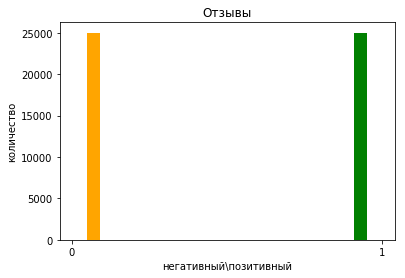

In [6]:
plt.hist([df.sentiment[df.sentiment == 1], df.sentiment[df.sentiment == 0]], color=['green', 'orange'])
plt.xlabel("негативный\позитивный")
plt.ylabel("количество")
plt.xticks(range(0, 2))
plt.title('Отзывы')
plt.show()

Дизбаланса классов нет. Это хорошо.

**Примените tf-idf преобразование. Используйте как отдельные токены, так и биграммы, отсейте английские стоп-слова, а также слова, которые встречаются реже, чем в двух отзывах, или чаще, чем в 50% отзывов (параметры min/max_df), не забудьте убрать l2 регуляризацию, которая по умолчанию включена **

In [7]:
# реже, чем в двух отзывах
min_df = 2/df.shape[0]
#чаще, чем в 50% отзывов
max_df = 0.5
#tfidf-преобазование по биграммам
from sklearn.feature_extraction.text import TfidfVectorizer
tf_vectorizer = TfidfVectorizer(stop_words = stopwords.words('english'), ngram_range=(1, 2), min_df=min_df, max_df = 0.5, norm=None)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.review, df.sentiment, test_size=0.30, random_state=17)

In [9]:
X_train_tfidf = tf_vectorizer.fit_transform(X_train)
X_test_tfidf = tf_vectorizer.transform(X_test)
X_train_tfidf.shape, X_test_tfidf.shape

((35000, 476389), (15000, 476389))

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
logreg = LogisticRegression(random_state = 17)
logreg.fit(X_train_tfidf, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=17, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [11]:
y_predL = logreg.predict(X_test_tfidf)

In [12]:
print(accuracy_score(y_test, y_predL))
# Ещё результаты
print("Classification Report для кросс-валидированной логистической классификации:")
print(classification_report(y_test, y_predL))

0.9064666666666666
Classification Report для кросс-валидированной логистической классификации:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      7438
           1       0.90      0.91      0.91      7562

   micro avg       0.91      0.91      0.91     15000
   macro avg       0.91      0.91      0.91     15000
weighted avg       0.91      0.91      0.91     15000



In [13]:
print("Confusion martrix for Logistic regression is :- \n")
print(confusion_matrix(y_test, y_predL))

Confusion martrix for Logistic regression is :- 

[[6688  750]
 [ 653 6909]]


In [14]:
coefs = pd.DataFrame(logreg.coef_).T
coefs.rename(columns = {0: 'coef'}, inplace = True)

bigram = pd.DataFrame(tf_vectorizer.get_feature_names())
bigram.rename(columns = {0: 'bigram'}, inplace = True)

bigram_importance = pd.concat([coefs, bigram], axis = 1)
bigram_importance = bigram_importance.sort_values(by = 'coef')
bigram_importance.tail()

,coef,bigram
56468,0.374624,brilliant
309944,0.390659,perfect
18367,0.397515,amazing
136057,0.485645,excellent
183111,0.489181,great


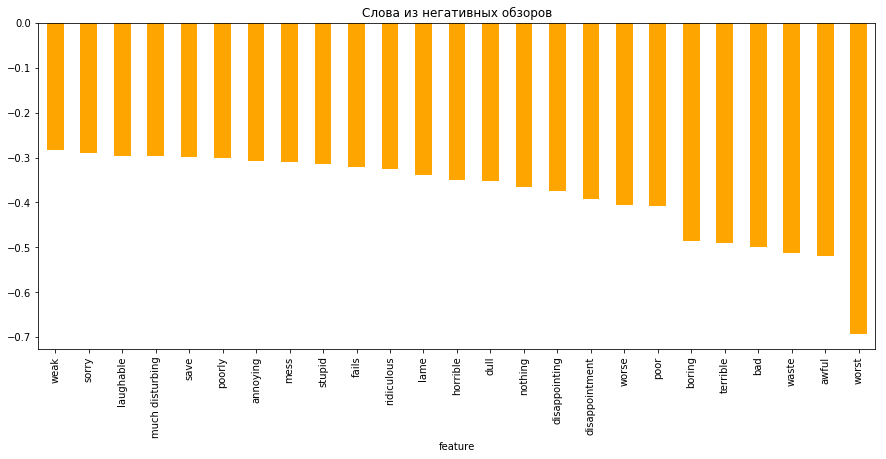

In [15]:
featureImportance = pd.DataFrame({"feature": bigram_importance.bigram[:25] , 
                                  "importance": bigram_importance.coef[:25]})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot('bar', figsize=(15, 6), color = 'orange', title = 'Слова из негативных обзоров');

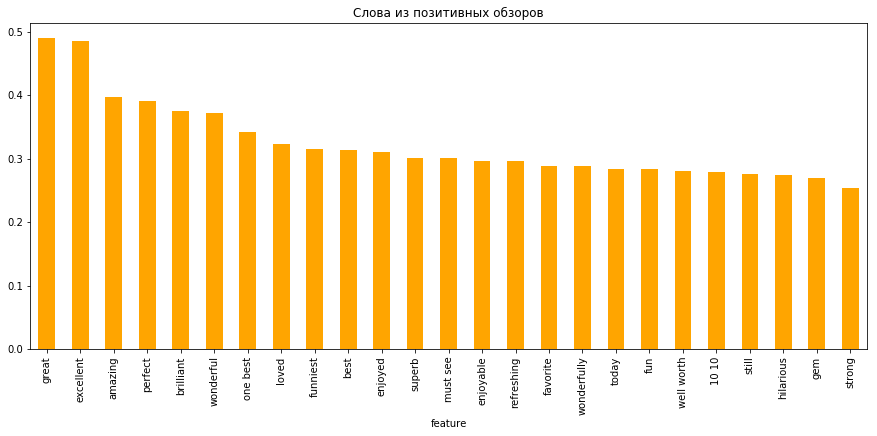

In [18]:
featureImportance = pd.DataFrame({"feature": bigram_importance.bigram[-25:] , 
                                  "importance": bigram_importance.coef[-25:]})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot('bar', figsize=(15, 6), color = 'orange', title = 'Слова из позитивных обзоров');